* https://www.kaggle.com/matevaradi/nyc-airbnb-geospatial-analysis-price-predictions/notebook
* https://developer.foursquare.com/reference/place-search
* https://github.com/gracecarrillo/Predicting-Airbnb-prices-with-machine-learning-and-location-data/blob/gh-pages/Exploring_Edinburgh_Graciela_Carrillo.ipynb

In [868]:
""" import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mplleaflet
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pygeoj
!{sys.executable} -m pip install pyshp
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install --upgrade cython
!conda install -c conda-forge libspatialindex -y
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install descartes
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install pandana
!{sys.executable} -m pip install xgboost 
!{sys.executable} -m pip install osmnet"""

' import sys\n!{sys.executable} -m pip install geopandas\n!{sys.executable} -m pip install mplleaflet\n!{sys.executable} -m pip install bs4\n!{sys.executable} -m pip install geocoder\n!{sys.executable} -m pip install geopy\n!{sys.executable} -m pip install folium\n!{sys.executable} -m pip install lxml\n!{sys.executable} -m pip install pygeoj\n!{sys.executable} -m pip install pyshp\n!{sys.executable} -m pip install datetime\n!{sys.executable} -m pip install seaborn\n!{sys.executable} -m pip install --upgrade cython\n!conda install -c conda-forge libspatialindex -y\n!{sys.executable} -m pip install geopandas\n!{sys.executable} -m pip install descartes\n!{sys.executable} -m pip install requests\n!{sys.executable} -m pip install pandana\n!{sys.executable} -m pip install xgboost \n!{sys.executable} -m pip install osmnet'

In [869]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import warnings
import seaborn as sns
import regex as re

# Geographical analysis
import geopandas as gpf #libspatialindex nees to be installed first
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


# delete warnings from output
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# figure size in inches
plt.rcParams['figure.figsize'] = 15, 12

# loading the datasets into pandas dataframes
listings = pd.read_csv("data/listings.csv")

In [870]:
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_since':'reviews_per_month'] = listings.loc[mask, 'host_since':'reviews_per_month'].shift(-1, axis=1)

In [871]:
listings['priv_bath'] = listings['bathrooms_text']
listings['bathrooms'] = listings['bathrooms_text']

# filter columns
listings = listings[["id", "host_id", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_total_listings_count", 
    "host_verifications", "host_identity_verified", "neighbourhood_cleansed", "latitude", "longitude", "property_type", "room_type",
    "accommodates", "priv_bath", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights","availability_90",
    "number_of_reviews", "number_of_reviews_ltm", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
    "review_scores_location", "review_scores_value", "instant_bookable", "reviews_per_month"]]

In [872]:
np.sort(listings.neighbourhood_cleansed.unique())

array(['Binnenstad', 'Bloemekenswijk', 'Brugse Poort - Rooigem',
       'Dampoort', 'Drongen', 'Elisabethbegijnhof - Papegaai',
       'Gentbrugge', 'Ledeberg', 'Macharius - Heirnis', 'Mariakerke',
       'Moscou - Vogelhoek', 'Muide - Meulestede - Afrikalaan',
       'Nieuw Gent - UZ', 'Oostakker', 'Oud Gentbrugge',
       'Rabot  - Blaisantvest', 'Sint Amandsberg', 'Sint Denijs Westrem',
       'Sluizeken - Tolhuis - Ham', 'Stationsbuurt Noord',
       'Stationsbuurt Zuid', 'Watersportbaan - Ekkergem', 'Wondelgem',
       'Zwijnaarde'], dtype=object)

In [873]:
map_df = gpf.read_file('data/geo/ghent.geojson')
np.sort(map_df.name.unique())
map_df.rename(columns={'name': 'neighbourhood'}, inplace=True)
map_df.drop(['descriptio', 'cartodb_id', 'created_at', 'updated_at'], axis=1, inplace=True)

In [874]:
map_df.head()

,neighbourhood,geometry
0,Dampoort,"MULTIPOLYGON (((3.74075 51.05856, 3.74085 51.0..."
1,Bloemekenswijk,"MULTIPOLYGON (((3.70664 51.07669, 3.70735 51.0..."
2,Rabot - Blaisantvest,"MULTIPOLYGON (((3.72743 51.06812, 3.72755 51.0..."
3,Moscou - Vogelhoek,"MULTIPOLYGON (((3.75658 51.03337, 3.75767 51.0..."
4,Wondelgem,"MULTIPOLYGON (((3.74379 51.11560, 3.74690 51.1..."


In [875]:
#listings = listings[listings['neighbourhood_cleansed'].notna()]
#listings = listings[listings['price'].notna()]
# clean property types
listings['property_type'] = ['Room'    if re.match('.*room.*', x, re.IGNORECASE) 
                                            else 'House' if re.match('.*house.*', x, re.IGNORECASE) 
                                            else 'Apartment' if re.match('.*apartment.*', x, re.IGNORECASE) 
                                            else 'Other'
                                            for x in listings["property_type"]]

# convert percentage to float
listings["host_response_rate"] = listings['host_response_rate'].str.rstrip('%').astype('float') / 100.0
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

# convert to number of verification types
listings['host_verifications'] = listings['host_verifications'].apply(eval).apply(lambda x: len(x))

# convert booleans: 1 if true, 0 if false
listings["host_identity_verified"] = listings["host_identity_verified"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["instant_bookable"] = listings["instant_bookable"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["host_is_superhost"] = listings["host_is_superhost"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)

# private bathroom and shared bathroom
listings['bathrooms'] = listings['bathrooms'].replace('\s.*', '', regex=True)
listings['bathrooms'] = listings['bathrooms'].replace('^[a-zA-Z].*', '0.5', regex=True)
listings['priv_bath'] = listings['priv_bath'].replace('.*ared.*', '0', regex=True)
listings['priv_bath'] = listings['priv_bath'].replace('.*[a-zA-Z].*', '1', regex=True)

listings['bathrooms'] = listings['bathrooms'].astype(float)
listings['priv_bath'] = listings['priv_bath'].astype(float)

# convert currency to float
listings['price'] = listings['price'].replace('[\$,)]', '', regex=True).astype(float)
listings.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

In [876]:
# first we drop the rows that contain missing values
listings.dropna(inplace=True)

# next we convert some columns to numeric values
listings[["accommodates", "bedrooms", "minimum_nights", "number_of_reviews", "review_scores_rating", "longitude", "beds", "host_id", "host_total_listings_count", "maximum_nights", "number_of_reviews_ltm"]] = listings[["accommodates","bedrooms", "minimum_nights", "number_of_reviews", "review_scores_rating", "longitude","beds", "host_id", "host_total_listings_count", "maximum_nights", "number_of_reviews_ltm"]].apply(pd.to_numeric)

In [877]:
# Replace categorical features with one-hot encodings
a = pd.get_dummies(listings['host_response_time'], prefix = "hrt")
b = pd.get_dummies(listings['room_type'], prefix = "rt")
c = pd.get_dummies(listings['property_type'], prefix = "pt")
frames = [listings, a, b, c]
listings = pd.concat(frames, axis = 1)

In [878]:
ghent_df = pd.DataFrame(listings.groupby('neighbourhood').size())
ghent_df.rename(columns={0: 'number_of_listings'}, inplace=True)
ghent_df['median_price'] = listings.groupby('neighbourhood').price.median().values

In [879]:
# Joining the dataframes
ghent_map_df = map_df.set_index('neighbourhood').join(ghent_df)

ghent_map_df.head()

,geometry,number_of_listings,median_price
neighbourhood,,,
Dampoort,"MULTIPOLYGON (((3.74075 51.05856, 3.74085 51.0...",32.0,54.0
Bloemekenswijk,"MULTIPOLYGON (((3.70664 51.07669, 3.70735 51.0...",10.0,93.5
Rabot - Blaisantvest,"MULTIPOLYGON (((3.72743 51.06812, 3.72755 51.0...",18.0,83.5
Moscou - Vogelhoek,"MULTIPOLYGON (((3.75658 51.03337, 3.75767 51.0...",2.0,46.0
Wondelgem,"MULTIPOLYGON (((3.74379 51.11560, 3.74690 51.1...",9.0,95.0


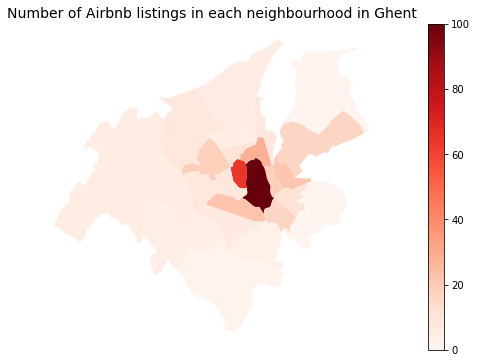

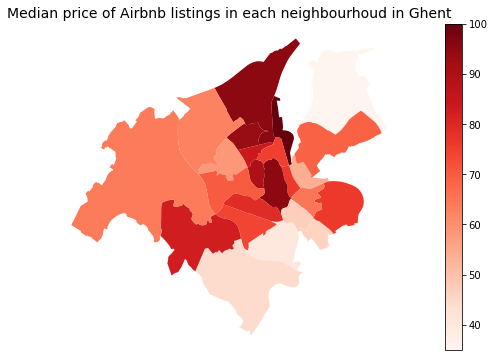

In [880]:
# Plotting the number of listings in each neighbourhoud
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
ghent_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each neighbourhood in Ghent', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each neighbourhoud
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
ghent_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each neighbourhoud in Ghent', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(ghent_map_df.median_price), vmax=max(ghent_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [881]:
type(map_df.geometry)

geopandas.geoseries.GeoSeries

In [882]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y
map_df.head()

,neighbourhood,geometry,longitude,latitude
0,Dampoort,"MULTIPOLYGON (((3.74075 51.05856, 3.74085 51.0...",3.750148,51.052590
1,Bloemekenswijk,"MULTIPOLYGON (((3.70664 51.07669, 3.70735 51.0...",3.707591,51.070787
2,Rabot - Blaisantvest,"MULTIPOLYGON (((3.72743 51.06812, 3.72755 51.0...",3.712477,51.063170
3,Moscou - Vogelhoek,"MULTIPOLYGON (((3.75658 51.03337, 3.75767 51.0...",3.759759,51.025928
4,Wondelgem,"MULTIPOLYGON (((3.74379 51.11560, 3.74690 51.1...",3.714999,51.091413


In [883]:
# Function to loop for places through all neighbourhoods
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v3/places/search?categories=10000,13000,14000,16000,18000&sort=POPULARITY&ll={},{}&radius={}&limit={}'.format(
            lat, 
            lng,
            radius,
            30)

        headers = {
            "Accept": "application/json",
            "Authorization": "fsq3cqB4ezOnNJEURfeUGEsdkG6rMTFrodDz5UwDZV3EWGM="
        }

        response = requests.request("GET", url, headers=headers).json()

        print(response)
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['geocodes']['main']['latitude'], 
            v['geocodes']['main']['longitude'],  
            v['categories'][0]['name']) for v in response.get('results')])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Place', 
                  'Place Latitude', 
                  'Place Longitude', 
                  'Place Category']
    
    return(nearby_venues)

In [884]:
# ghent_places = getNearbyVenues(names=map_df['neighbourhood'], latitudes=map_df['latitude'], longitudes=map_df['longitude'], radius = 500)

In [885]:
# ghent_places.head()

In [886]:
# Saving Data set
# ghent_places.to_csv('data/geo/ghent_places.csv')

In [887]:
ghent_places = pd.read_csv('data/geo/ghent_places.csv', index_col=0)

In [888]:
ghent_places.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category
Neighbourhood,,,,,,
Binnenstad,30,30,30,30,30,30
Bloemekenswijk,30,30,30,30,30,30
Brugse Poort - Rooigem,30,30,30,30,30,30
Dampoort,30,30,30,30,30,30
Drongen,4,4,4,4,4,4
Elisabethbegijnhof - Papegaai,30,30,30,30,30,30
Gentbrugge,30,30,30,30,30,30
Kanaaldorpen en -zone,3,3,3,3,3,3
Ledeberg,30,30,30,30,30,30


In [889]:
print('There are {} unique categories.'.format(len(ghent_places['Place Category'].unique())))

There are 130 unique categories.


In [890]:
ghent_places['Place Category'].unique()

array(['Park', 'Pub', 'Bakery', 'Kebab Restaurant',
       'Historic and Protected Site', 'Sports Club', 'Plaza',
       'Coffee Shop', 'Fast Food Restaurant', 'Dance Studio', 'Bar',
       'Concert Hall', 'Doner Restaurant', 'Bistro', 'Comedy Club',
       'Playground', 'Snack Place', 'Friterie', 'Sports and Recreation',
       'Monument', 'Science Museum', 'Bathing Area', 'Turkish Restaurant',
       'Pizzeria', 'Yoga Studio', 'Gym and Studio', 'Dog Park',
       'Tennis Court', 'Garden', 'Cafeteria', 'Hookah Bar', 'Brasserie',
       'Canal', 'Theater', 'Comfort Food Restaurant', 'Bridge',
       'Landmarks and Outdoors', 'Deli', 'Boxing Gym', 'Asian Restaurant',
       'Sandwich Restaurant', 'Skate Park', 'Arts and Entertainment',
       'Restaurant', 'Equestrian Facility', 'Dining and Drinking',
       'Pool Hall', 'Latin American Restaurant', 'History Museum', 'Farm',
       'Whisky Bar', 'Music Venue', 'Swimming Pool', 'Soccer Field',
       'Bike Trail', 'Gastropub', 'Sushi Res

In [891]:
ghent_places.groupby('Place Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude
Place Category,,,,,,
Amusement Park,1,1,1,1,1,1
Arts and Entertainment,6,6,6,6,6,6
Asian Restaurant,1,1,1,1,1,1
BBQ Joint,3,3,3,3,3,3
Bagel Shop,1,1,1,1,1,1
...,...,...,...,...,...,...
Vegan and Vegetarian Restaurant,5,5,5,5,5,5
Vietnamese Restaurant,2,2,2,2,2,2
Whisky Bar,1,1,1,1,1,1


In [892]:
# One Hot Encoding
ghent_onehot = pd.get_dummies(ghent_places[['Place Category']], prefix = "", prefix_sep = "")

## Add neighbourhood column back to df
ghent_onehot['Neighbourhood'] = ghent_places['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [ghent_onehot.columns[-1]] + list(ghent_onehot.columns[:-1])
ghent_onehot = ghent_onehot[fixed_columns]

# display
ghent_onehot.head()

,Neighbourhood,Amusement Park,Arts and Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,...,Theater,Track,Tunnel,Turkish Restaurant,VR Cafe,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dampoort,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dampoort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [893]:
# New df dimensions
ghent_onehot.shape

(661, 131)

In [894]:
ghent_grouped = ghent_onehot.groupby('Neighbourhood').mean().reset_index()
ghent_grouped

,Neighbourhood,Amusement Park,Arts and Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,...,Theater,Track,Tunnel,Turkish Restaurant,VR Cafe,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,Binnenstad,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bloemekenswijk,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
2,Brugse Poort - Rooigem,0.000000,0.000000,0.000000,0.033333,0.000000,0.066667,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Dampoort,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.066667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Drongen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Elisabethbegijnhof - Papegaai,0.000000,0.066667,0.000000,0.066667,0.000000,0.033333,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
6,Gentbrugge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Kanaaldorpen en -zone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Ledeberg,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000
9,Macharius - Heirnis,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [895]:
num_top_places = 5

for hood in ghent_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = ghent_grouped[ghent_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['place','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_places))
    print('\n')

----Binnenstad----
                place  freq
0                 Bar  0.33
1              Bakery  0.10
2         Coffee Shop  0.10
3  Italian Restaurant  0.07
4               Plaza  0.07


----Bloemekenswijk----
              place  freq
0            Bakery  0.17
1               Bar  0.10
2             Plaza  0.07
3  Doner Restaurant  0.07
4          Friterie  0.07


----Brugse Poort - Rooigem----
                place  freq
0                Park  0.17
1                 Bar  0.10
2              Bakery  0.07
3  Turkish Restaurant  0.07
4            Friterie  0.07


----Dampoort----
          place  freq
0        Bakery  0.17
1    Playground  0.07
2  Concert Hall  0.07
3         Plaza  0.07
4           Bar  0.07


----Drongen----
                    place  freq
0            Bathing Area  0.25
1                     Bar  0.25
2  Landmarks and Outdoors  0.25
3                  Bridge  0.25
4                   Plaza  0.00


----Elisabethbegijnhof - Papegaai----
                  place  freq


In [896]:
# Function to sort places in descending order
def return_most_common_places(row, num_top_places):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_places]

In [897]:
import numpy as np

# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_places):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = ghent_grouped['Neighbourhood']

for ind in np.arange(ghent_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_places(ghent_grouped.iloc[ind, :], 
                                                                          num_top_places)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Binnenstad,Bar,Bakery,Coffee Shop,Italian Restaurant,Plaza
1,Bloemekenswijk,Bakery,Bar,Plaza,Doner Restaurant,Friterie
2,Brugse Poort - Rooigem,Park,Bar,Bakery,Turkish Restaurant,Friterie
3,Dampoort,Bakery,Playground,Concert Hall,Plaza,Bar
4,Drongen,Bathing Area,Bar,Landmarks and Outdoors,Bridge,Plaza


In [898]:
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 13 unique categories.


In [899]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

,Neighbourhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1st Most Common Venue,,,,,
Bakery,5,5,5,5,5
Bar,6,6,6,6,6
Bathing Area,1,1,1,1,1
Cafeteria,1,1,1,1,1
Harbor / Marina,1,1,1,1,1
Park,4,4,4,4,4
Playground,1,1,1,1,1
Plaza,1,1,1,1,1
Pub,1,1,1,1,1


In [900]:

ghent_places['Place Category'].value_counts()

Bar               82
Park              53
Bakery            53
Plaza             29
Friterie          20
                  ..
Breakfast Spot     1
Hockey Field       1
Track              1
Rugby Pitch        1
Cocktail Bar       1
Name: Place Category, Length: 130, dtype: int64

In [901]:
#Get just Pub, Cafe, Bar And Restaurant

# Points of interest already exists. Load from ghent_places
df_pois = ghent_places.copy()
terms = ['Bar', 'Pub', 'Restaurant', 'Café', 'Bakery', 'Park', 'Bridge', 'Plaza', 'Friterie']
terms = ['Park','Plaza']
df_pois = df_pois[df_pois['Place Category'].str.contains('|'.join(terms))]
df_pois.to_csv('data/geo/foursquare_amenities.csv', index=id, header=True)
method = 'loaded from CSV'

df_pois.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category
0,Dampoort,51.052590,3.750148,Bijgaardepark,51.050959,3.743387,Park
6,Dampoort,51.052590,3.750148,Heernisplein,51.052589,3.748513,Plaza
20,Dampoort,51.052590,3.750148,Banierpark,51.053710,3.745673,Park
26,Dampoort,51.052590,3.750148,Heilig-Hartplein,51.053776,3.748884,Plaza
30,Bloemekenswijk,51.070787,3.707591,Edmond van Beverenplein,51.072428,3.709838,Plaza


In [902]:
df_pois.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Place                       object
Place Latitude             float64
Place Longitude            float64
Place Category              object
dtype: object

In [903]:
df_pois['Place Category'].value_counts()

Park                53
Plaza               29
Dog Park            11
Skate Park           3
Pedestrian Plaza     1
Amusement Park       1
Name: Place Category, dtype: int64

In [904]:
# Put all restaurant, bar, pub... places together under same name
df_pois.loc[df_pois['Place Category'].str.contains('Restaurant', case=False), 'Place Category'] = 'Restaurant'
df_pois.loc[df_pois['Place Category'].str.contains('Bar', case=False), 'Place Category'] = 'Bar'
df_pois.loc[df_pois['Place Category'].str.contains('Pub', case=False), 'Place Category'] = 'Pub'
df_pois.loc[df_pois['Place Category'].str.contains('Bakery', case=False), 'Place Category'] = 'Bakery'
df_pois.loc[df_pois['Place Category'].str.contains('Park', case=False), 'Place Category'] = 'Park'
df_pois.loc[df_pois['Place Category'].str.contains('Bridge', case=False), 'Place Category'] = 'Bridge'
df_pois.loc[df_pois['Place Category'].str.contains('Plaza', case=False), 'Place Category'] = 'Plaza'
df_pois.loc[df_pois['Place Category'].str.contains('Friterie', case=False), 'Place Category'] = 'Friterie'

df_pois['Place Category'].value_counts()

Park     68
Plaza    30
Name: Place Category, dtype: int64

In [905]:
# configure filenames to save/load network datasets

# Edinburgh's bounding box found here: https://boundingbox.klokantech.com/
bbox = (3.579762,50.979639,3.849325,51.187946)
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)

In [906]:
network = osm.pdna_network_from_bbox(bbox=bbox)
method = 'downloaded from OSM'

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](50.97963900,3.57976200,51.18794600,3.84932500);>;);out;'}"
Downloaded 22,295.5KB from www.overpass-api.de in 7.16 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 7.81 seconds
Returning OSM data with 155,167 nodes and 32,107 ways...
Edge node pairs completed. Took 25.21 seconds
Returning processed graph with 38,101 nodes and 52,970 edges...
Completed OSM data download and Pandana node and edge table creation in 35.41 seconds
Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 38101
Setting CH edge vector of size 53578
Range graph removed 2810 edges of 107156
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% .

In [907]:
print(type(network))

<class 'pandana.network.Network'>


In [908]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

# remove low-connectivity nodes and save to h5
network.save_hdf5('data/geo/mynetwork.h5',rm_nodes=lcn)

In [909]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
distance = 3000
num_pois = 10
num_categories = len(df_pois['Place']) + 1 #one for each amenity, plus one extra for all of them combined

In [910]:
## precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [911]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [912]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
# with ghent_places subset df_pois
network.set_pois(category='all', x_col = df_pois['Place Longitude'], y_col = df_pois['Place Latitude'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [913]:
# searches for the n-nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returns a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head() # Distance in meters to ten nearest amenities

38,101 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
145715,353.725006,1565.907959,1671.979980,1871.175049,1914.338013,1970.681030,3000.000000,3000.000000,3000.000000,3000.000000
145718,1029.902954,1073.066040,1094.316040,1159.344971,1211.444946,2058.305908,2378.381104,2388.412109,2450.528076,2450.528076
145758,183.182999,322.066986,345.324005,884.395020,1183.447021,1214.854980,1241.224976,1272.090942,1430.374023,1444.271973
145761,484.263000,534.515015,556.270996,698.341980,1169.191040,1395.677002,1531.151978,1559.415039,1616.651001,1794.076050
145763,529.357971,868.934021,890.690002,1032.760986,1045.088013,1509.442017,1509.442017,1511.979980,1543.465942,1544.394043


In [914]:
bbox = [3.579762,50.979639,3.849325,51.187946]

In [915]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'Reds', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'Reds'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Reds', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

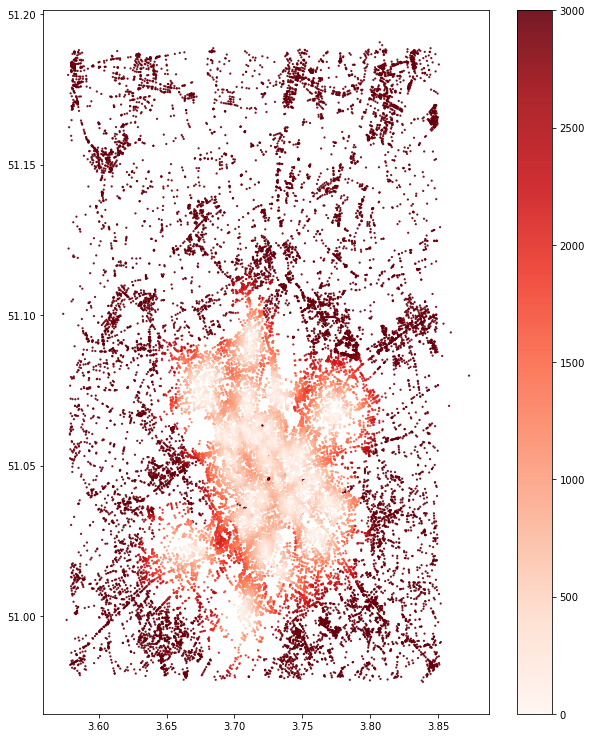

In [916]:
# distance to the nearest amenity of any type
n = 1
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                            cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Ghent', fontsize=15)
fig.savefig('data/geo/accessibility-ghent.png', dpi=200, bbox_inches='tight')

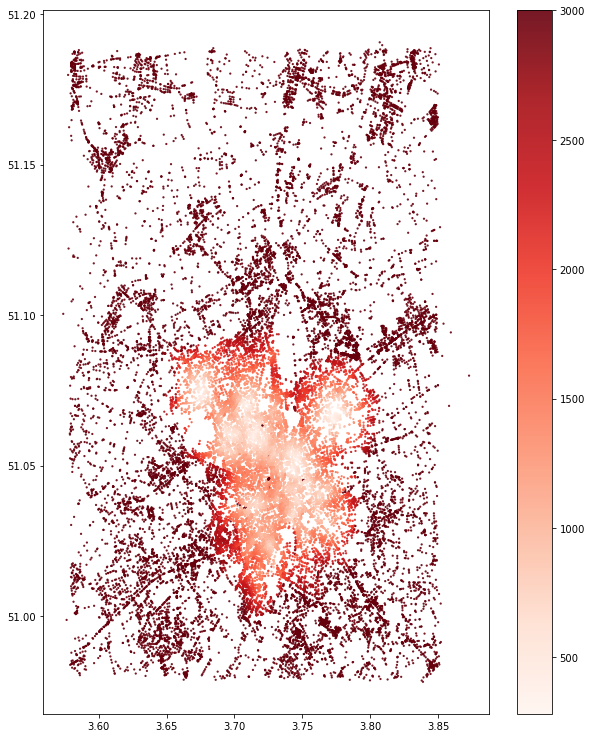

In [917]:
# distance to the 5th nearest amenity of any type
n = 5
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Ghent', fontsize=15)
fig.savefig('data/geo/accessibility-nearest5th-ghent.png', dpi=200, bbox_inches='tight')

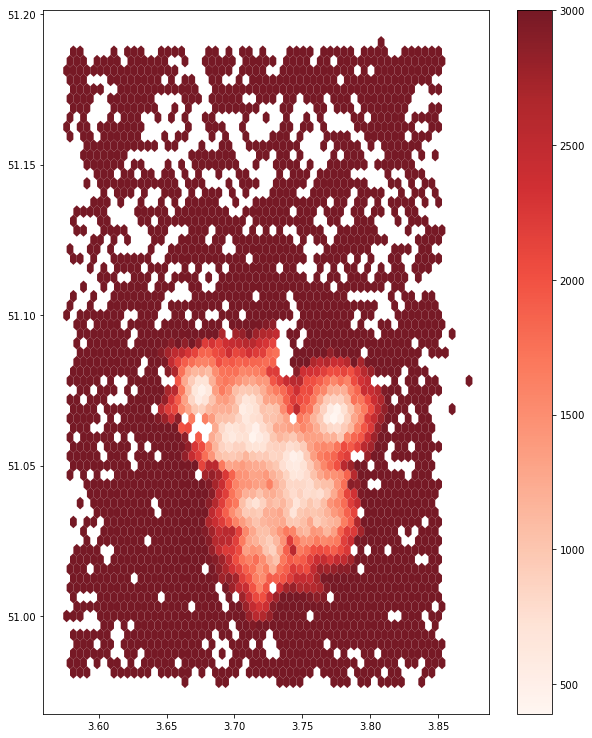

In [918]:
# distance to the 5th nearest amenity of any type, as hexbins
n=5
fig, ax = network.plot(all_access[n], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Ghent', fontsize=15)
fig.savefig('data/geo/accessibility-hexbins-ghent.png', dpi=200, bbox_inches='tight')

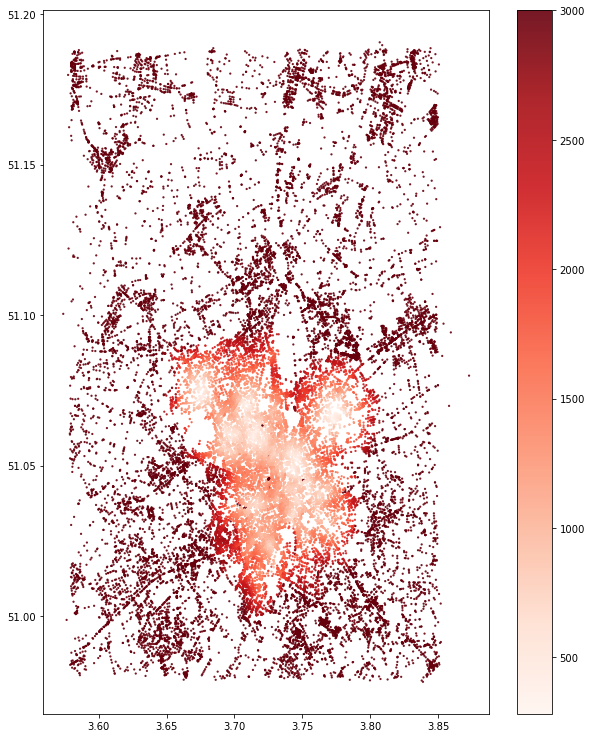

In [919]:
# distance to the 5th nearest amenity of any type
n = 5
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Ghent', fontsize=15)
fig.savefig('data/geo/accessibility-nearest5th-ghent.png', dpi=200, bbox_inches='tight')

In [920]:
# retreive the 5th nearest amenities (of all types) to each node in the network
num_pois = 5
N_nearest_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the 5 POIs
print('{:,} nodes'.format(len(N_nearest_access)))

Access_Score = pd.DataFrame(N_nearest_access[5])
Access_Score.head()

38,101 nodes


,5
id,
145715,1914.338013
145718,1211.444946
145758,1183.447021
145761,1169.191040
145763,1045.088013


In [921]:
# We name our measure 'Score'
Access = Access_Score.rename(columns={5:'Score'})
Access.head()
Access.dtypes

Score    float64
dtype: object

In [922]:
df_pois['node_ids'] = network.get_node_ids(df_pois['Place Longitude'], df_pois['Place Latitude'])
df_pois.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category,node_ids
0,Dampoort,51.052590,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735
6,Dampoort,51.052590,3.750148,Heernisplein,51.052589,3.748513,Plaza,266908652
20,Dampoort,51.052590,3.750148,Banierpark,51.053710,3.745673,Park,8729747899
26,Dampoort,51.052590,3.750148,Heilig-Hartplein,51.053776,3.748884,Plaza,268860875
30,Bloemekenswijk,51.070787,3.707591,Edmond van Beverenplein,51.072428,3.709838,Plaza,2598932226


In [923]:
#pois_sub.reset_index(level=0, inplace=True) # convert index into column
Access.reset_index(level=0, inplace=True)

In [924]:
# Set both columns to have the same names
Access = Access.rename(columns={'id':'node_ids'})
Access.head()

,node_ids,Score
0,145715,1914.338013
1,145718,1211.444946
2,145758,1183.447021
3,145761,1169.191040
4,145763,1045.088013


In [925]:
# Merging by node_ids
merged = pd.merge(df_pois, Access, on='node_ids')

In [926]:
merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category,node_ids,Score
0,Dampoort,51.052590,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007
1,Macharius - Heirnis,51.050029,3.739631,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007
2,Dampoort,51.052590,3.750148,Heernisplein,51.052589,3.748513,Plaza,266908652,573.445007
3,Dampoort,51.052590,3.750148,Banierpark,51.053710,3.745673,Park,8729747899,573.250000
4,Dampoort,51.052590,3.750148,Heilig-Hartplein,51.053776,3.748884,Plaza,268860875,612.911011


<AxesSubplot:>

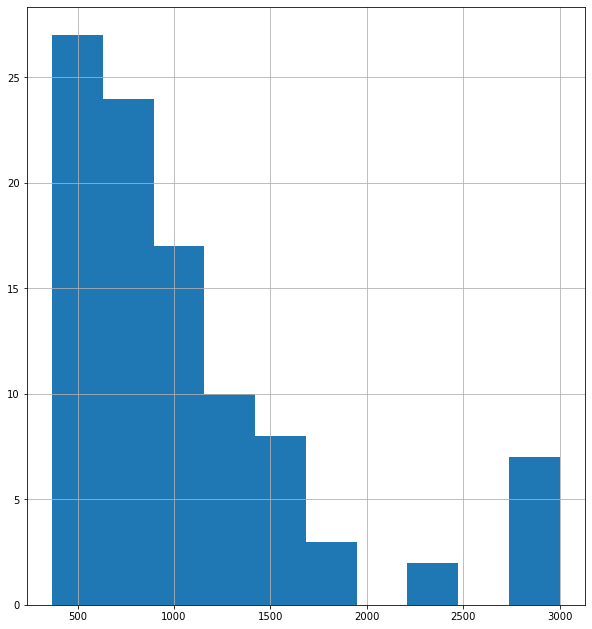

In [927]:
merged['Score'].hist(figsize=(10,11))

In [928]:
listings.rename(columns={'neighbourhood': 'Neighbourhood'}, inplace=True)

In [929]:
listings_merged = pd.merge(merged, listings, on='Neighbourhood')

In [930]:
listings_merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category,node_ids,Score,id,...,hrt_within a few hours,hrt_within an hour,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room,pt_Apartment,pt_House,pt_Other,pt_Room
0,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,9087777,...,0,1,0,0,1,0,0,0,0,1
1,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,10083084,...,0,1,0,0,1,0,0,0,0,1
2,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,11454300,...,0,1,1,0,0,0,1,0,0,0
3,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,12423613,...,0,1,1,0,0,0,0,0,1,0
4,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,14541839,...,1,0,1,0,0,0,1,0,0,0


In [931]:
# Save cleaned for modelling
listings_merged.to_csv('data/listings_model_with_geo.csv', index=id, header=True)

In [932]:
# Open merged dataset for modelling
df_merged = pd.read_csv('data/listings_model_with_geo.csv', index_col=0)
df_merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category,node_ids,Score,id,...,hrt_within a few hours,hrt_within an hour,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room,pt_Apartment,pt_House,pt_Other,pt_Room
0,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,9087777,...,0,1,0,0,1,0,0,0,0,1
1,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,10083084,...,0,1,0,0,1,0,0,0,0,1
2,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,11454300,...,0,1,1,0,0,0,1,0,0,0
3,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,12423613,...,0,1,1,0,0,0,0,0,1,0
4,Dampoort,51.05259,3.750148,Bijgaardepark,51.050959,3.743387,Park,2468647735,573.445007,14541839,...,1,0,1,0,0,0,1,0,0,0


In [933]:
# Dropping variables no longer needed
df_merged.drop(['Neighbourhood Longitude', 'Place Latitude', 'Place Longitude','Neighbourhood Latitude',
               'Place Category', 'node_ids', 'Place'], axis=1, inplace=True)

TODO: Add model that makes price depending on the geolocation and the nearest places (from foursquare).

In [934]:
tfo_listings = df_merged[["id", "Score", "host_total_listings_count", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "number_of_reviews"]]

for col in ["Score", "host_total_listings_count", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "number_of_reviews"]:
    tfo_listings[col] = tfo_listings[col].astype('float64').replace(0.0, 0.01)
    tfo_listings[col] = np.log(tfo_listings[col])

In [935]:
# Separating X and y
X = tfo_listings.drop('price', axis=1)
y = tfo_listings.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [936]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

In [937]:
hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))


Training RMSE: 0.1583
Validation RMSE: 0.15

Training r2: 0.5088
Validation r2: 0.5626


In [938]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,4.736198,4.547098
1,3.637586,3.937695
2,4.595120,4.510662
3,4.262680,4.109585
4,3.135494,3.991541
...,...,...
443,4.499810,4.501558
444,3.970292,4.055098
445,3.806662,4.031936
446,4.248495,4.170889


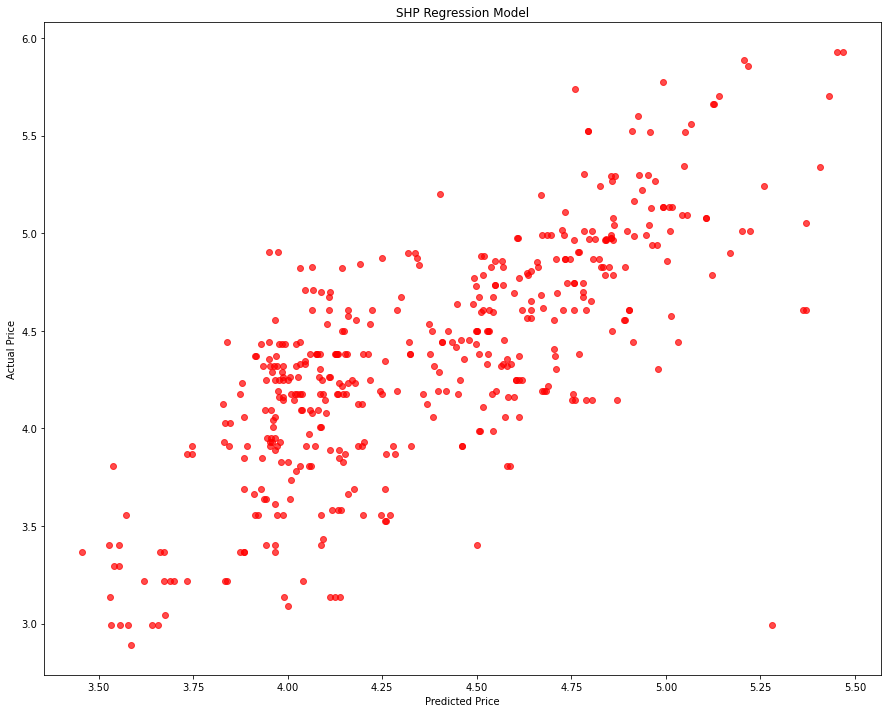

In [939]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

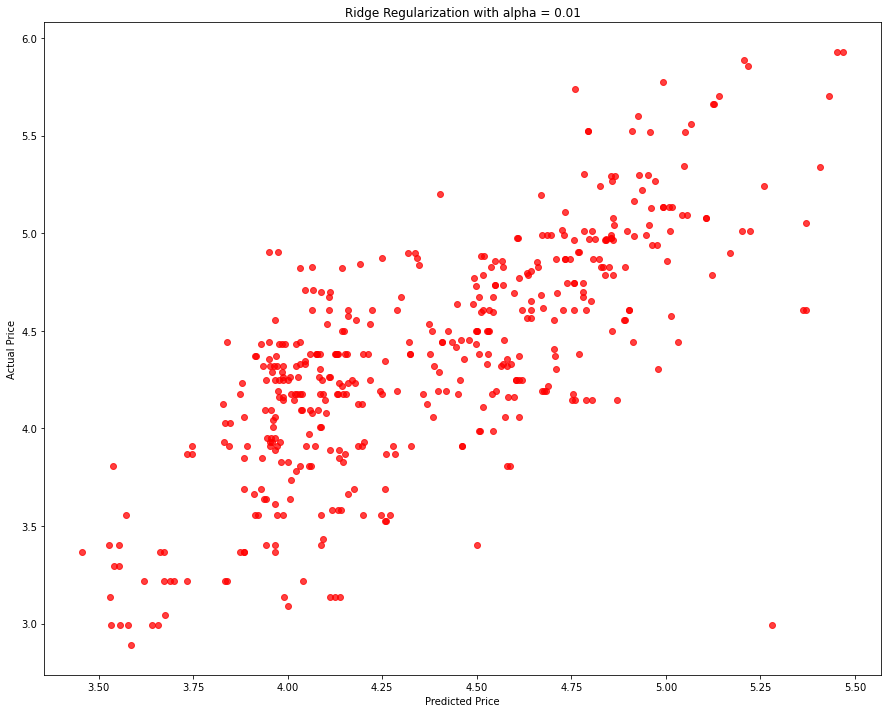

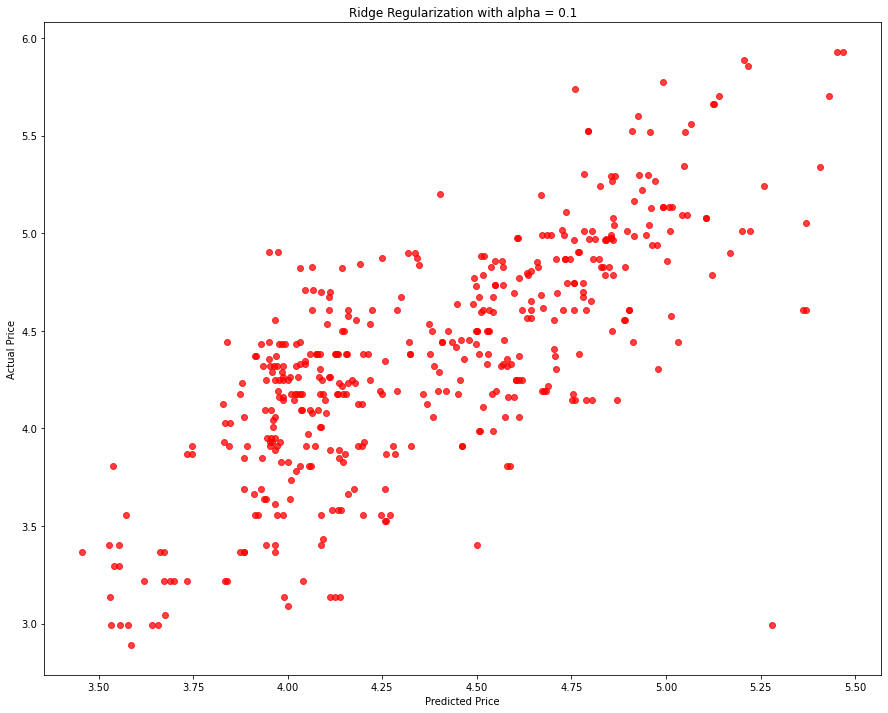

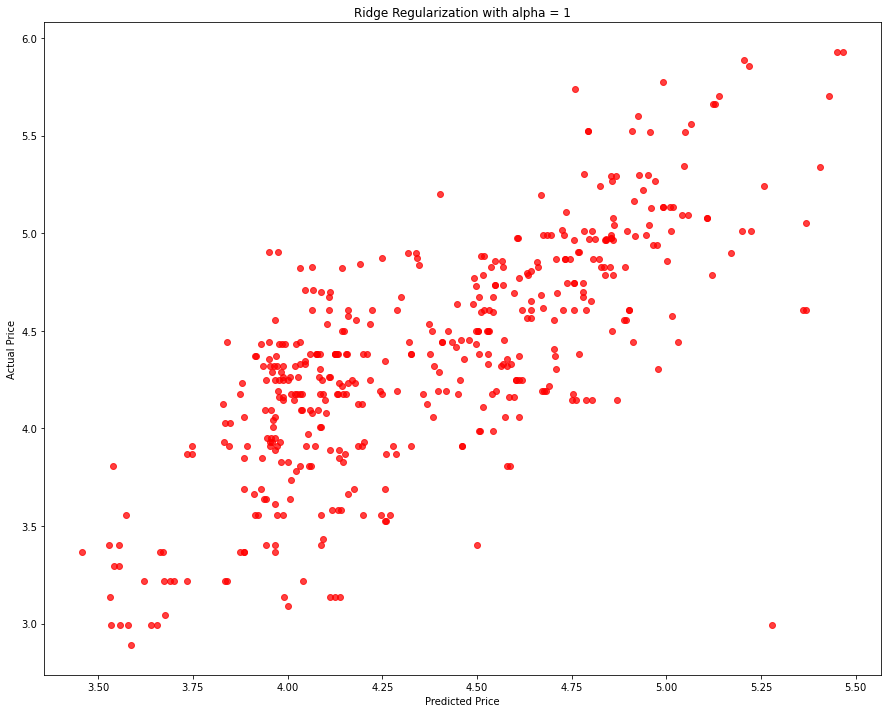

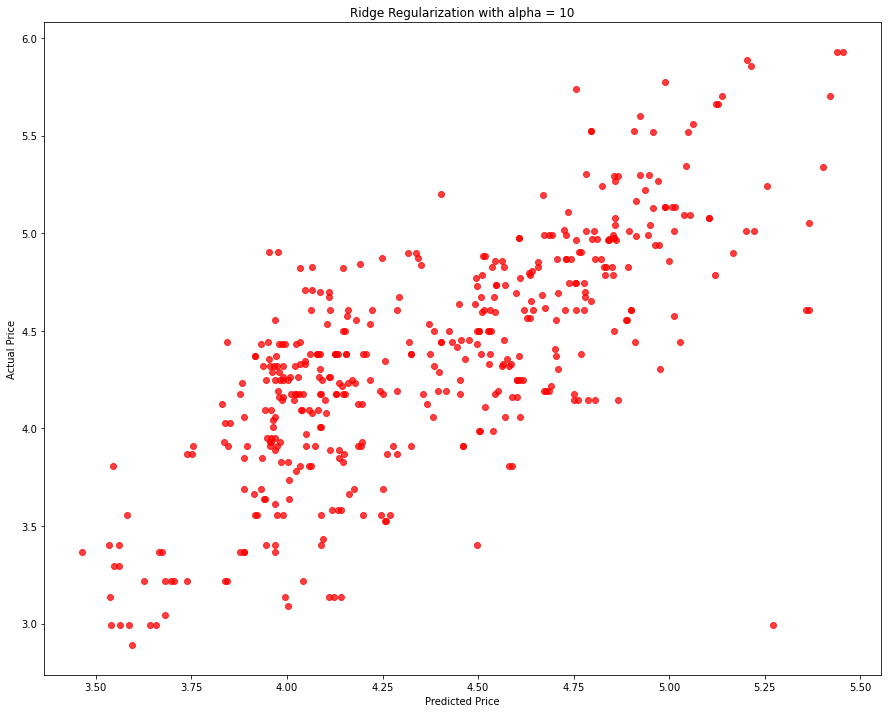

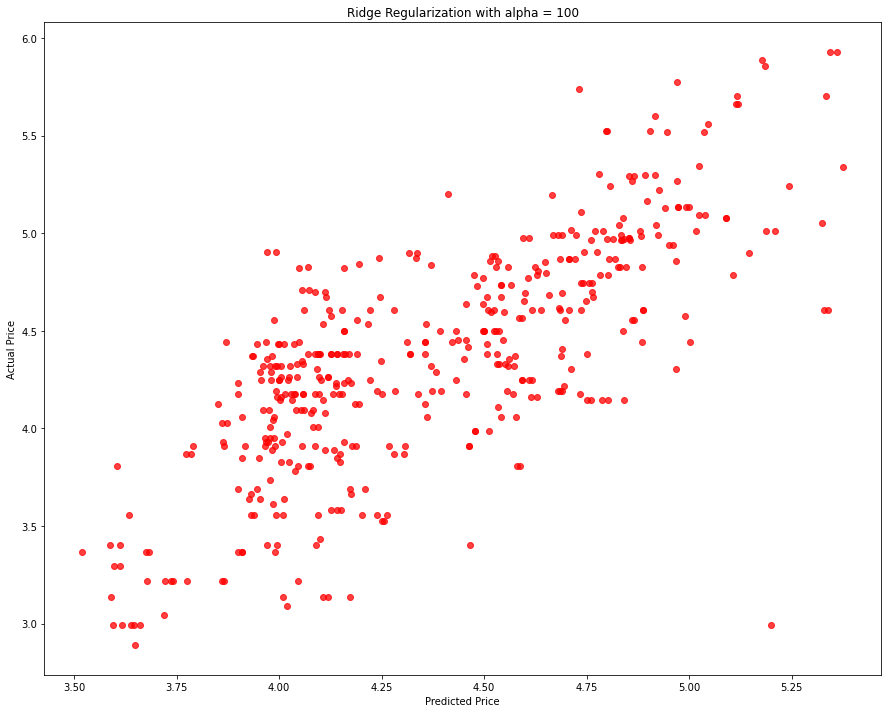

In [940]:
lr = linear_model.LinearRegression()

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='r')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                   round(ridge_model.score(X_test, y_test), 4),
                    round(mean_squared_error(y_train, training_preds_hpm_reg),4))
    plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
    plt.show()

In [941]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 0.0008
Validation MSE: 0.0168

Training r2: 0.9974
Validation r2: 0.9511


In [942]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
bedrooms,0.394898
accommodates,0.376077
bathrooms,0.044793
beds,0.040293
minimum_nights,0.036832
number_of_reviews,0.029442
maximum_nights,0.027255
id,0.020861
host_total_listings_count,0.014994
Score,0.014554


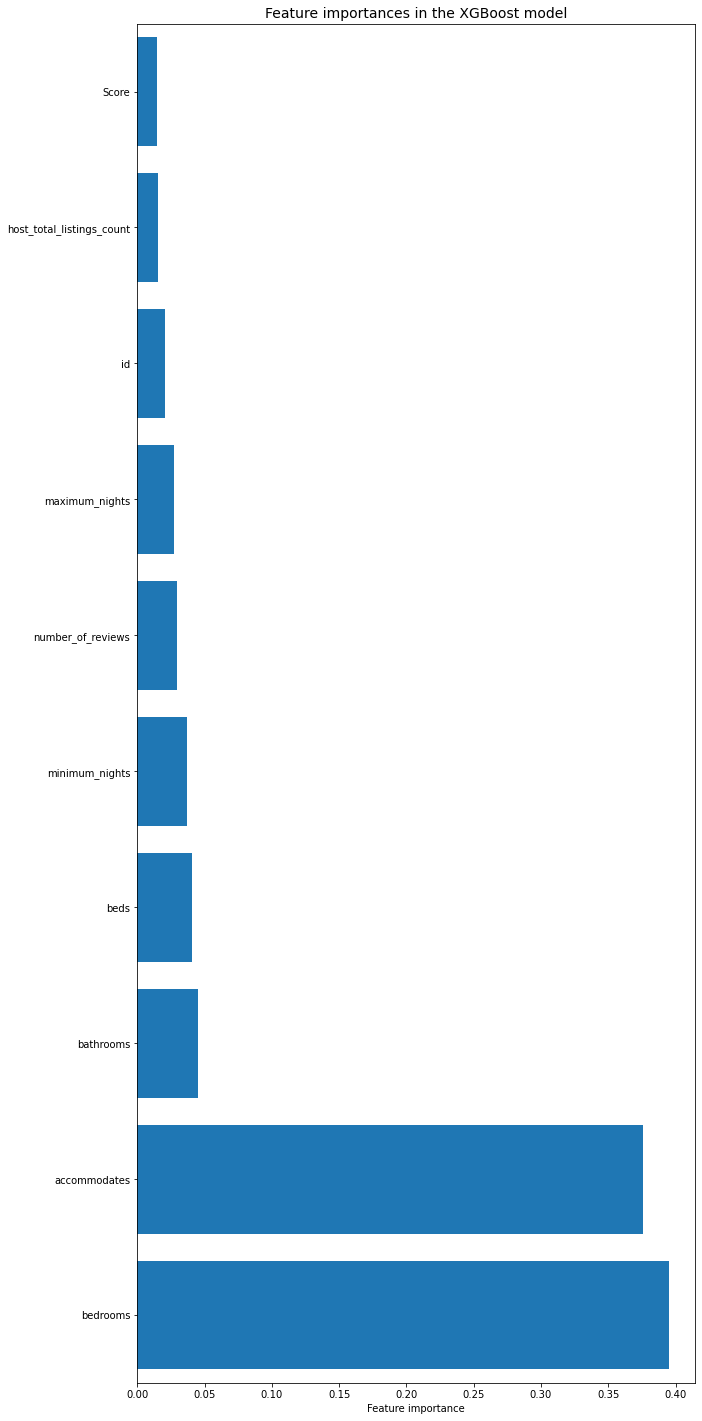

In [943]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()